# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, MultiprocessingEvaluator)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from statistics import mean

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [167]:
ema_logging.log_to_stderr(ema_logging.INFO)

#We can define common uncertainties and outcomes for each model:
uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
            TimeSeriesOutcome('predators', function=np.squeeze),
            TimeSeriesOutcome('prey', function=np.squeeze)]


#Define the Python model
py_model = Model('Python', function=pred_prey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes


nr_experiments = 100

#Using Latin Hypercube sampling
experiments, outcomes = perform_experiments(py_model, nr_experiments, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [168]:
experiments.head()

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.001659,0.002256,0.073105,0.030655,26200,None,Python
1,0.000540,0.002355,0.048265,0.026679,26201,None,Python
2,0.001896,0.001191,0.075798,0.032325,26202,None,Python
3,0.001527,0.002187,0.076540,0.026877,26203,None,Python
4,0.002599,0.001671,0.079454,0.030543,26204,None,Python


In [169]:
experiments

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.001659,0.002256,0.073105,0.030655,26200,None,Python
1,0.000540,0.002355,0.048265,0.026679,26201,None,Python
2,0.001896,0.001191,0.075798,0.032325,26202,None,Python
3,0.001527,0.002187,0.076540,0.026877,26203,None,Python
4,0.002599,0.001671,0.079454,0.030543,26204,None,Python
...,...,...,...,...,...,...,...
95,0.001214,0.002043,0.067225,0.021353,26295,None,Python
96,0.002168,0.002133,0.059714,0.022629,26296,None,Python
97,0.001713,0.003349,0.046368,0.019330,26297,None,Python
98,0.000605,0.003055,0.068362,0.023450,26298,None,Python


# Part 1

### Regression

In [170]:
# calculate final outcomes
final_outcomes_prey = []

for i in range(len(outcomes['prey'])):
    final_outcomes_prey.append((outcomes['prey'][i][-1]))

In [171]:
# calculate mean values of prey over time 
mean_outcomes_prey = []

for i in range(len(outcomes['prey'])):
    mean_outcomes_prey.append(mean((outcomes['prey'][i])))

In [172]:
# calculate standard deviation over time
std_outcomes_prey = []

for i in range(len(outcomes['prey'])):
    std_outcomes_prey.append(np.std(((outcomes['prey'][i]))))

In [173]:
# Fit a linear regression model for the final outcomes
x = experiments[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]

reg_mod_final = sm.OLS(final_outcomes_prey, x)
res_fin = reg_mod_final.fit()


print(res_fin.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.794
Model:                            OLS   Adj. R-squared (uncentered):              0.785
Method:                 Least Squares   F-statistic:                              92.44
Date:                Fri, 07 May 2021   Prob (F-statistic):                    4.68e-32
Time:                        15:46:58   Log-Likelihood:                         -415.44
No. Observations:                 100   AIC:                                      838.9
Df Residuals:                      96   BIC:                                      849.3
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [174]:
res_fin.fittedvalues

0     42.451726
1     21.381028
2     58.169735
3     43.973813
4     53.529079
        ...    
95    36.023778
96    29.168249
97     2.919223
98    26.168425
99    15.339711
Length: 100, dtype: float64

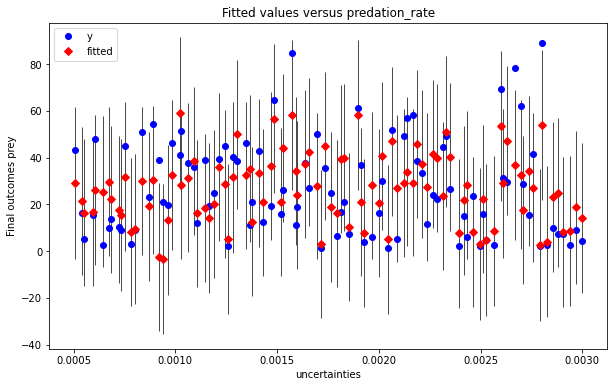

In [175]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_fin, 0, ax=ax)
fig.set_size_inches(10, 6, forward=True)
ax.set_ylabel("Final outcomes prey")
ax.set_xlabel("uncertainties")

plt.show()

In [176]:
predation=[]
for i in range(len(experiments)):
    predation.append(experiments.iloc[i,0])
predator_efficiency=[]
for i in range(len(experiments)):
    predator_efficiency.append(experiments.iloc[i,1])
predator_loss_rate=[]
for i in range(len(experiments)):
    predator_loss_rate.append(experiments.iloc[i,2])
prey_birth=[]
for i in range(len(experiments)):
    prey_birth.append(experiments.iloc[i,3])

In [177]:
ys = res_fin.fittedvalues.values
predation, ys = zip(*sorted(zip(predation, ys)))
predator_efficiency, ys =zip(*sorted(zip(predator_efficiency, ys)))
predator_loss_rate, ys =zip(*sorted(zip(predator_loss_rate, ys)))
prey_birth, ys =zip(*sorted(zip(prey_birth, ys)))

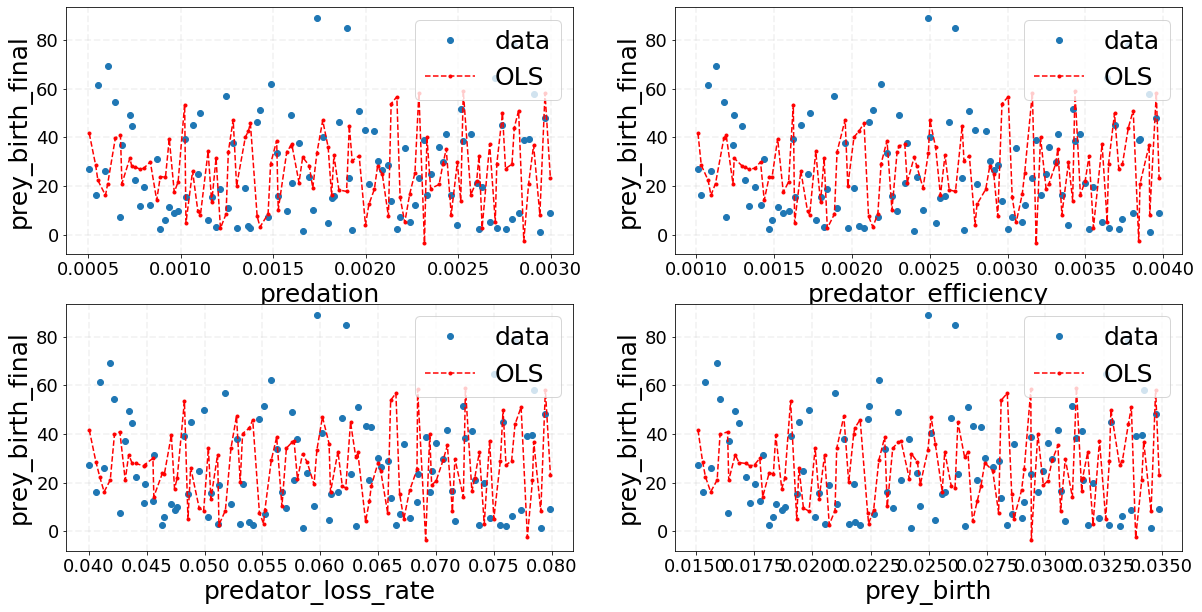

In [178]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].plot(predation,final_outcomes_prey, 'o', label="data")
ax[0,0].tick_params(labelsize=18)
ax[0,0].plot(predation, ys, 'r--.', label="OLS")
ax[0,0].set_xlabel('predation',fontsize=25)
ax[0,0].set_ylabel('prey_birth_final',fontsize=25)
ax[0,0].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[0,0].legend(fontsize=25,loc="upper right");

ax[0,1].plot(predator_efficiency,final_outcomes_prey, 'o', label="data")
ax[0,1].tick_params(labelsize=18)
ax[0,1].plot(predator_efficiency, ys, 'r--.', label="OLS")
ax[0,1].set_xlabel('predator_efficiency',fontsize=25)
ax[0,1].set_ylabel('prey_birth_final',fontsize=25)
ax[0,1].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[0,1].legend(fontsize=25,loc="upper right");

ax[1,0].plot(predator_loss_rate,final_outcomes_prey, 'o', label="data")
ax[1,0].tick_params(labelsize=18)
ax[1,0].plot(predator_loss_rate, ys, 'r--.', label="OLS")
ax[1,0].set_xlabel('predator_loss_rate',fontsize=25)
ax[1,0].set_ylabel('prey_birth_final',fontsize=25)
ax[1,0].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[1,0].legend(fontsize=25,loc="upper right");

ax[1,1].plot(prey_birth,final_outcomes_prey, 'o', label="data")
ax[1,1].tick_params(labelsize=18)
ax[1,1].plot(prey_birth, ys, 'r--.', label="OLS")
ax[1,1].set_xlabel('prey_birth',fontsize=25)
ax[1,1].set_ylabel('prey_birth_final',fontsize=25)
ax[1,1].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[1,1].legend(fontsize=25,loc="upper right");

# Fit a linear regression model for the mean values over time

In [179]:
x = experiments[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]

reg_mod_mean = sm.OLS(mean_outcomes_prey, x)
res_mean = reg_mod_mean.fit()


print(res_mean.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              649.4
Date:                Fri, 07 May 2021   Prob (F-statistic):                    1.47e-68
Time:                        15:47:00   Log-Likelihood:                         -315.70
No. Observations:                 100   AIC:                                      639.4
Df Residuals:                      96   BIC:                                      649.8
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

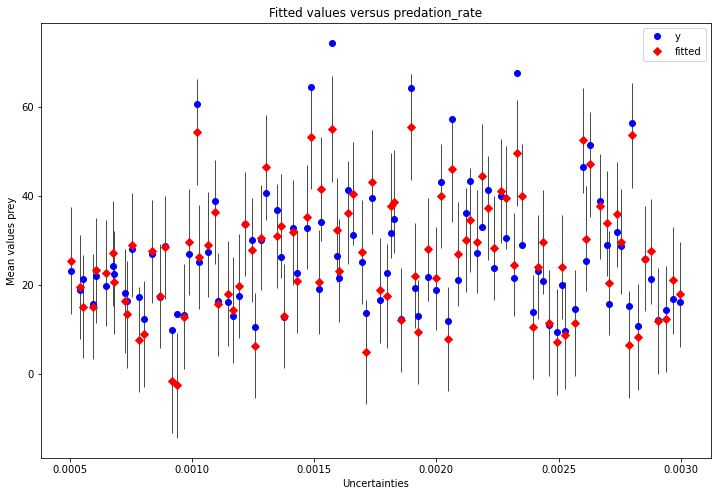

In [180]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_mean, 0, ax=ax)
fig.set_size_inches(12, 8, forward=True)
ax.set_ylabel("Mean values prey")
ax.set_xlabel("Uncertainties")

plt.show()

# Fit a linear regression model for the standard deviations over time

In [181]:
x = experiments[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]

reg_mod_std = sm.OLS(std_outcomes_prey, x)
res_std = reg_mod_std.fit()

print(res_std.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              436.6
Date:                Fri, 07 May 2021   Prob (F-statistic):                    1.19e-60
Time:                        15:47:01   Log-Likelihood:                         -265.13
No. Observations:                 100   AIC:                                      538.3
Df Residuals:                      96   BIC:                                      548.7
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

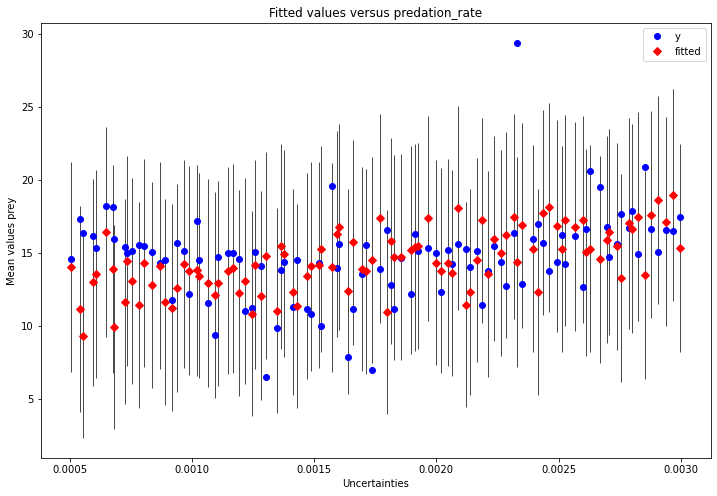

In [182]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_std, 0, ax=ax)
fig.set_size_inches(12, 8, forward=True)
ax.set_ylabel("Mean values prey")
ax.set_xlabel("Uncertainties")

plt.show()

# Part2

### SOBOL sampling

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

# N=50

In [214]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

sa_results = perform_experiments(py_model, scenarios=50, uncertainty_sampling='sobol')
#now we have 50*(2*4+2)=500 scenarios

[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] experiments finished


In [215]:
experiments, outcomes = sa_results

mean_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    mean_outcomes_prey.append(mean(outcomes['prey'][i]))
mean_outcomes_prey=np.array(mean_outcomes_prey)

std_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    std_outcomes_prey.append(np.std(outcomes['prey'][i]))
std_outcomes_prey=np.array(std_outcomes_prey)

problem = get_SALib_problem(py_model.uncertainties)
Si_final = sobol.analyze(problem, outcomes['prey'][:,-1],
                   calc_second_order=True, print_to_console=False)
Si_mean = sobol.analyze(problem, mean_outcomes_prey,
                   calc_second_order=True, print_to_console=False)
Si_std = sobol.analyze(problem, std_outcomes_prey,
                   calc_second_order=True, print_to_console=False)


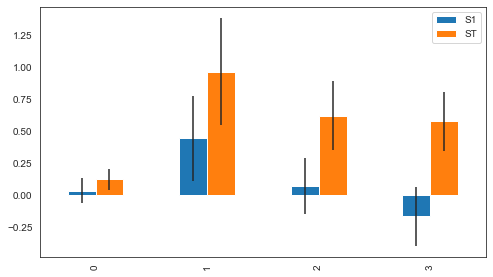

In [216]:
scores_filtered = {k:Si_final[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_finalplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_finalplot[['S1','ST']]
err = Si_finalplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

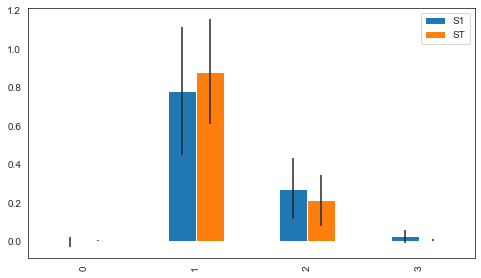

In [217]:
scores_filtered = {k:Si_mean[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_meanplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_meanplot[['S1','ST']]
err = Si_meanplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

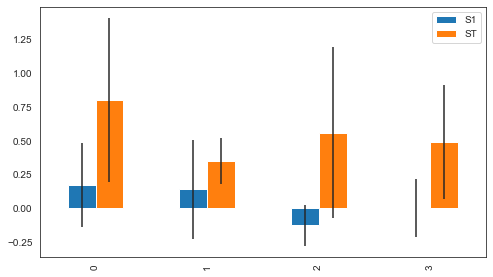

In [218]:
scores_filtered = {k:Si_std[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_stdplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_stdplot[['S1','ST']]
err = Si_stdplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [219]:
print("x1-x2:", Si_final['S2'][0,1], "with confidence interval 95%:", Si_final['S2_conf'][0,1])
print("x1-x3:", Si_final['S2'][0,2], "with confidence interval 95%:", Si_final['S2_conf'][0,2])
print("x1-x4:", Si_final['S2'][0,3], "with confidence interval 95%:", Si_final['S2_conf'][0,3])
print("x2-x3:", Si_final['S2'][1,2], "with confidence interval 95%:", Si_final['S2_conf'][1,2])
print("x2-x4:", Si_final['S2'][1,3], "with confidence interval 95%:", Si_final['S2_conf'][1,3])
print("x3-x4:", Si_final['S2'][2,3], "with confidence interval 95%:", Si_final['S2_conf'][2,3])

x1-x2: -0.05123729249469189 with confidence interval 95%: 0.19532315117607021
x1-x3: 0.016940679815702853 with confidence interval 95%: 0.10422517062211961
x1-x4: -0.03579535645537915 with confidence interval 95%: 0.1318935071081132
x2-x3: -0.14820321287428648 with confidence interval 95%: 0.2996584925237491
x2-x4: 0.0926491726293173 with confidence interval 95%: 0.29355866222754706
x3-x4: 0.2229366430247306 with confidence interval 95%: 0.20580632887848244


# N=250

In [220]:
sa_results = perform_experiments(py_model, scenarios=250, uncertainty_sampling='sobol')
#now we have 1000*(2*4+2)=10000 scenarios

[MainProcess/INFO] performing 2500 scenarios * 1 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


In [221]:
experiments, outcomes = sa_results

mean_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    mean_outcomes_prey.append(mean(outcomes['prey'][i]))
mean_outcomes_prey=np.array(mean_outcomes_prey)

std_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    std_outcomes_prey.append(np.std(outcomes['prey'][i]))
std_outcomes_prey=np.array(std_outcomes_prey)

problem = get_SALib_problem(py_model.uncertainties)
Si_final = sobol.analyze(problem, outcomes['prey'][:,-1],
                   calc_second_order=True, print_to_console=False)
Si_mean = sobol.analyze(problem, mean_outcomes_prey,
                   calc_second_order=True, print_to_console=False)
Si_std = sobol.analyze(problem, std_outcomes_prey,
                   calc_second_order=True, print_to_console=False)

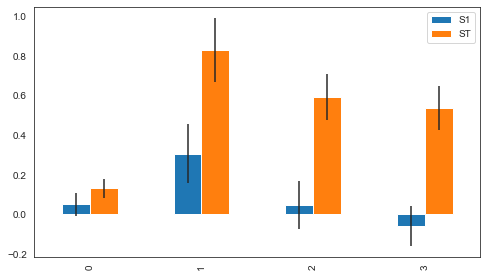

In [222]:
scores_filtered = {k:Si_final[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_finalplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_finalplot[['S1','ST']]
err = Si_finalplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

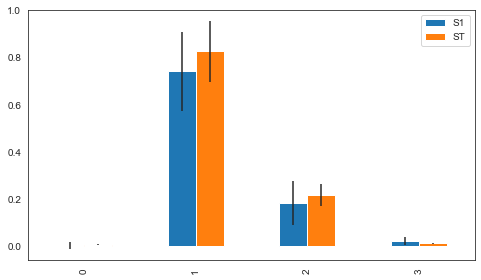

In [223]:
scores_filtered = {k:Si_mean[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_meanplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_meanplot[['S1','ST']]
err = Si_meanplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

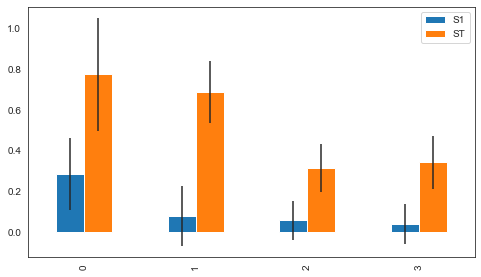

In [224]:
scores_filtered = {k:Si_std[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_stdplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_stdplot[['S1','ST']]
err = Si_stdplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [225]:
print("x1-x2:", Si_final['S2'][0,1], "with confidence interval 95%:", Si_final['S2_conf'][0,1])
print("x1-x3:", Si_final['S2'][0,2], "with confidence interval 95%:", Si_final['S2_conf'][0,2])
print("x1-x4:", Si_final['S2'][0,3], "with confidence interval 95%:", Si_final['S2_conf'][0,3])
print("x2-x3:", Si_final['S2'][1,2], "with confidence interval 95%:", Si_final['S2_conf'][1,2])
print("x2-x4:", Si_final['S2'][1,3], "with confidence interval 95%:", Si_final['S2_conf'][1,3])
print("x3-x4:", Si_final['S2'][2,3], "with confidence interval 95%:", Si_final['S2_conf'][2,3])

x1-x2: 0.018420391550688697 with confidence interval 95%: 0.1009026978429507
x1-x3: -0.03630289786484633 with confidence interval 95%: 0.10092197476012289
x1-x4: -0.029596670956394254 with confidence interval 95%: 0.09553214650423904
x2-x3: 0.05349767522019151 with confidence interval 95%: 0.21302437596690865
x2-x4: 0.1531451902189415 with confidence interval 95%: 0.18600268178019777
x3-x4: 0.17252536407172 with confidence interval 95%: 0.1456031357102629


# N=1000

In [226]:
sa_results = perform_experiments(py_model, scenarios=1000, uncertainty_sampling='sobol')
#now we have 1000*(2*4+2)=10000 scenarios

[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


In [227]:
experiments, outcomes = sa_results

mean_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    mean_outcomes_prey.append(mean(outcomes['prey'][i]))
mean_outcomes_prey=np.array(mean_outcomes_prey)

std_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    std_outcomes_prey.append(np.std(outcomes['prey'][i]))
std_outcomes_prey=np.array(std_outcomes_prey)

problem = get_SALib_problem(py_model.uncertainties)
Si_final = sobol.analyze(problem, outcomes['prey'][:,-1],
                   calc_second_order=True, print_to_console=False)
Si_mean = sobol.analyze(problem, mean_outcomes_prey,
                   calc_second_order=True, print_to_console=False)
Si_std = sobol.analyze(problem, std_outcomes_prey,
                   calc_second_order=True, print_to_console=False)

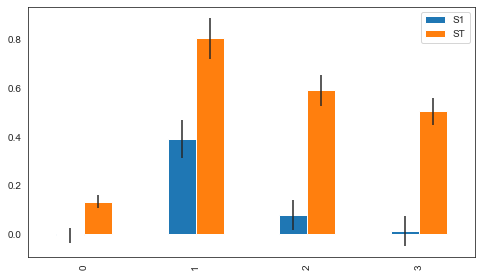

In [228]:
scores_filtered = {k:Si_final[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_finalplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_finalplot[['S1','ST']]
err = Si_finalplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

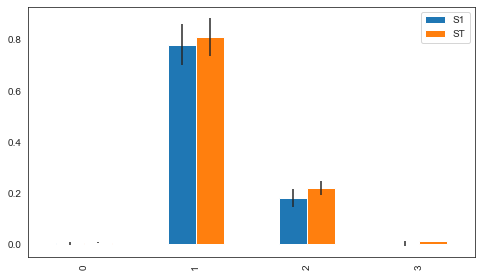

In [229]:
scores_filtered = {k:Si_mean[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_meanplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_meanplot[['S1','ST']]
err = Si_meanplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

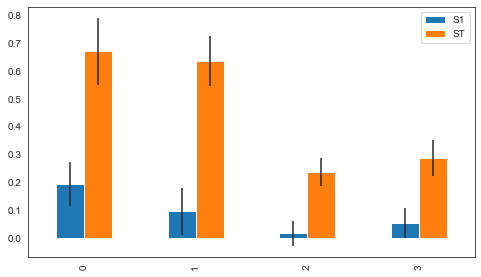

In [230]:
scores_filtered = {k:Si_std[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_stdplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_stdplot[['S1','ST']]
err = Si_stdplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [231]:
print("x1-x2:", Si_final['S2'][0,1], "with confidence interval 95%:", Si_final['S2_conf'][0,1])
print("x1-x3:", Si_final['S2'][0,2], "with confidence interval 95%:", Si_final['S2_conf'][0,2])
print("x1-x4:", Si_final['S2'][0,3], "with confidence interval 95%:", Si_final['S2_conf'][0,3])
print("x2-x3:", Si_final['S2'][1,2], "with confidence interval 95%:", Si_final['S2_conf'][1,2])
print("x2-x4:", Si_final['S2'][1,3], "with confidence interval 95%:", Si_final['S2_conf'][1,3])
print("x3-x4:", Si_final['S2'][2,3], "with confidence interval 95%:", Si_final['S2_conf'][2,3])

x1-x2: 0.0148056506477105 with confidence interval 95%: 0.05077434959771549
x1-x3: 0.0029257806704469647 with confidence interval 95%: 0.03985573794445128
x1-x4: 0.01393612361851194 with confidence interval 95%: 0.04194034668241943
x2-x3: -0.06437870412465789 with confidence interval 95%: 0.09426649870648937
x2-x4: -0.034508420932226294 with confidence interval 95%: 0.09991289622540084
x3-x4: 0.0685440141593773 with confidence interval 95%: 0.08915933725837095


# Si and St

The first-order sensitivity index Si accounts for the contribution of the factor Xi to the output variation.
The total-order sensitivity index STi accounts for all the contributions to the output variation due to factor Xi (i.e. first-order index plus
all its interactions).

# Part 3

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [243]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes['prey']

fs = feature_scoring.get_ex_feature_scores(x,y,nr_trees=100, max_features=0.6,mode=RuleInductionType.REGRESSION)


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
C:\Users\Quint\Anaconda3\envs\gds\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


IndexError: Inconsistent shape between the condition and the input (got (2, 1) and (2,))

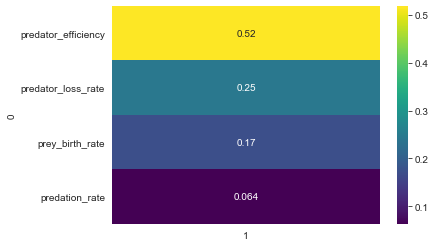

In [253]:
sns.heatmap(fs[0], cmap='viridis', annot=True)
plt.show()